In [ ]:
#pip install textblob

In [298]:
!pip install wordcloud

     -------------------------------------- 153.3/153.3 kB 1.1 MB/s eta 0:00:00


In [2]:
pip install pyspellchecker

     ---------------------------------------- 3.4/3.4 MB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [305]:
pip install transformers

     ---------------------------------------- 7.4/7.4 MB 1.5 MB/s eta 0:00:00
     -------------------------------------- 266.6/266.6 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 268.8/268.8 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [334]:
!pip install imblearn

     ------------------------------------ 235.6/235.6 kB 267.1 kB/s eta 0:00:00
     ------------------------------------ 302.2/302.2 kB 176.3 kB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [1537]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

import re
import string

from textblob import TextBlob
from spellchecker import SpellChecker

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
raw_data = pd.read_csv('C:/Users/ketan/Downloads/twitter_parsed_dataset.csv')

In [4]:
raw_data.head(5)

index                     id  \
0  5.74948705591165E+017  5.74948705591165E+017   
1  5.71917888690393E+017  5.71917888690393E+017   
2  3.90255841338601E+017  3.90255841338601E+017   
3  5.68208850655916E+017  5.68208850655916E+017   
4  5.75596338802373E+017  5.75596338802373E+017   

                                                Text Annotation  oh_label  
0  @halalflaws @biebervalue @greenlinerzjm I read...       none       0.0  
1  @ShreyaBafna3 Now you idiots claim that people...       none       0.0  
2  RT @Mooseoftorment Call me sexist, but when I ...     sexism       1.0  
3  @g0ssipsquirrelx Wrong, ISIS follows the examp...     racism       1.0  
4                             #mkr No No No No No No       none       0.0

In [5]:
raw_data.shape

(16851, 5)

In [6]:
raw_data['id'].duplicated().sum()

0

In [7]:
raw_data['Text'].duplicated().sum()

0

In [8]:
raw_data['index'].duplicated().sum()

0

In [9]:
raw_data.duplicated().sum()

0

In [10]:
raw_data.drop(columns=['index','id'],inplace=True)

In [11]:
raw_data.head(5)

Text Annotation  oh_label
0  @halalflaws @biebervalue @greenlinerzjm I read...       none       0.0
1  @ShreyaBafna3 Now you idiots claim that people...       none       0.0
2  RT @Mooseoftorment Call me sexist, but when I ...     sexism       1.0
3  @g0ssipsquirrelx Wrong, ISIS follows the examp...     racism       1.0
4                             #mkr No No No No No No       none       0.0

In [12]:
raw_data['Annotation'].value_counts()

none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64

In [13]:
raw_data['oh_label'].value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [14]:
pd.crosstab(index=raw_data['oh_label'],columns=raw_data['Annotation'],margins=True)

Annotation   none  racism  sexism    All
oh_label                                
0.0         11501       0       0  11501
1.0             0    1970    3377   5347
All         11501    1970    3377  16848

In [15]:
raw_data.isna().sum()

Text          1
Annotation    3
oh_label      3
dtype: int64

In [16]:
raw_data = raw_data.dropna()

In [17]:
raw_data['Text'][1]

'@ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.'

In [18]:
'tom@'.isalpha()

False

In [19]:
def change_case_lower(text):
    sample = " ".join([x.lower() for x in text.split()])
    
    return sample

def remove_url(text):
    sample = re.sub(r"\S*https?:\S*", '', text) #links and urls
    
    return sample

def remove_html(text):
    comp = re.compile(r'<.*?>')
    sample = re.sub(comp, '', text)
    
    return sample

def remove_punctuations(text):
    sample1 = re.sub('\[.*?\]', '', text) #text between [square brackets]
    sample2 = re.sub('\(.*?\)', '', sample1) #text between (parenthesis)
    sample3 = re.sub('[%s]' % re.escape(string.punctuation), '', sample2) #punctuations
    sample = re.sub("[''""...“”‘’…]", '', sample3) #list of quotation marks
    
    return sample

def remove_special_characters(text):
    sample1 = re.sub(r'\n', ' ', text) #new line character
    sample2 = re.sub(r'\\n', ' ', sample1) #new line character
    sample3 = ' '.join([w for w in nltk.wordpunct_tokenize(sample2) if w.lower().isalpha()==True])
    sample4 = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample3.split()))) #languages other than english
    sample = " ".join([x.strip() for x in sample4.split()])
    
    return sample

def remove_emojis(text):
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', text) #emojis and symbols
    return sample

In [20]:
s = """@DrBiden Ask Joe about his thoughts <b> on packing </b> the Supreme Court. 😅😄 He seem to have any after 50 years in
    politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ
    РУКАМИ into your search engIne and https://t.co/omPuIJzVnl"""

    only_english = set(nltk.corpus.words.words())#+list(nltk.corpus.wordnet.words()))

    remove_special_characters(s)#w.lower() in only_english or w.isalpha()
'DrBiden Ask Joe about his thoughts b on packing b the Supreme Court He seem to have any after years in politics JoeBiden more
sinister Covid News Just enter empty testing stations into your search engIne and https t co omPuIJzVnl'

    remove_special_characters(s)#w.lower() in only_english
'Ask Joe about his b on b the Supreme Court He seem to have any after in politics more sinister Covid News Just enter empty
testing into your search engIne and t'

    remove_special_characters(s)#w.lower() in only_english or not w.isalpha()
'Ask Joe about his b on packing b the Supreme Court He seem to have any after years in politics more sinister Covid19UK Covid
News Just enter empty testing stations into your search engIne and t co'

    remove_special_characters(s)#w.lower() in only_english #only_english is modified one here,with wordnet+words.
'Ask Joe about his b on packing b the Supreme Court He seem to have any after years in politics more sinister Covid News Just
enter empty testing stations into your search engIne and t co'

In [21]:
'kings' in list(nltk.corpus.wordnet.words())

False

In [22]:
'king' in nltk.corpus.words.words()

True

In [23]:
remove_emojis(s)

'@DrBiden Ask Joe about his thoughts <b> on packing </b> the Supreme Court.  He seem to have any after 50 years in\n    politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ\n    РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

In [ ]:
def clean_text(text):

    sample = " ".join([x.lower() for x in text.split()])
    sample = re.sub(r'@[\w]+','',sample) #To remove twitter usernames like @carry
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub(r', /<[^>]+>/', '', sample) #HTML attributes
    sample = re.sub(r'\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub(r'\(.*?\)', '', sample) #text between (parenthesis)
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample)]) #To avoid removal of words like '.Ketan,!My',words that are written right after punctuation without space.
    sample = re.sub(r'[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub(r"[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r'\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character

    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower().isalpha()==True]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    
    sample = " ".join([x.strip() for x in sample.split()])
    sample = str(TextBlob(sample).correct())
    
    return sample

In [25]:
k = 'DrBiden asks Joe about his thoughts on packing the supreme court hgfuvhvh'

In [26]:
spell = SpellChecker()
spell.correction("abou")

'abou'

In [27]:
clean_text(k)

'driven asks joe about his thoughts on packing the supreme court hgfuvhvh'

In [108]:
raw_data_sub = raw_data.sample(4000).reset_index(drop=True)

In [109]:
raw_data_sub.head(5)

Text Annotation  oh_label
0  Ok I'm done. That mole got through, outrageous...       none       0.0
1  @FrankAlvarez see this thread. :P https://t.co...       none       0.0
2  RT @_chonz Call me sexist, but I couldn't watc...     sexism       1.0
3  @ummayman90 When people leave Islam, they don'...     racism       1.0
4  @DianH4 Your scum hero Baghdadi's men rape mor...       none       0.0

In [117]:
raw_data_sub['Cleaned_text'] = raw_data_sub['Text'].apply(lambda x: clean_text(x))

In [118]:
raw_data_sub.head(2)

Text Annotation  oh_label  \
0  Ok I'm done. That mole got through, outrageous...       none       0.0   
1  @FrankAlvarez see this thread. :P https://t.co...       none       0.0   

                                      Cleaned_text  
0  ok i m done that mole got through outrageous mr  
1                                see this thread p

In [142]:
raw_data_sub = raw_data_sub.drop(columns='Text')

In [119]:
stops = set(stopwords.words('english'))
def remove_stop_words(text):
    
    sample = text.lower()
    sample = [w for w in sample.split() if not w in stops]
    sample = ' '.join(sample)
    
    return sample

In [140]:
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text):
 
    sample = text.split()
    sample = [lemmatizer.lemmatize(word.lower()) for word in sample]
    sample = ' '.join(sample)
    
    return sample


# Stemming the data
ps = PorterStemmer()
def stem_clean_text(text):
 
    sample = text.split()
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample

In [136]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def correct_text(text, stem=False, lemma=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text.lower()
    sample = [word for word in sample.split() if word not in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower()) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    return sample

In [147]:
raw_data_sub['Correct_text'] = raw_data_sub['Cleaned_text'].apply(lambda x: correct_text(x,stem=True))
raw_data_sub = raw_data_sub.drop(columns='Cleaned_text')

In [148]:
raw_data_sub.head()

Annotation  oh_label                                       Correct_text
0       none       0.0                         ok done mole got outrag mr
1       none       0.0                                       see thread p
2     sexism       1.0        call exist watch women stand ball inch band
3     racism       1.0          peopl leav slam announc quietli walk away
4       none       0.0  sum hero baghdadi men rape women everi singl d...

In [241]:
#Custom features
raw_data_sub['word_count'] = raw_data_sub['Correct_text'].apply(lambda x: len(str(x).split()))
raw_data_sub[['Correct_text','word_count']]

Correct_text  word_count
0                            ok done mole got outrag mr           6
1                                          see thread p           3
2           call exist watch women stand ball inch band           8
3             peopl leav slam announc quietli walk away           7
4     sum hero baghdadi men rape women everi singl d...          14
5           ann reaction lloyd said dinner land hate mr           8
6     obviou blond limb make better accord channel s...          10
7                                                                 0
8           mr andr must feel f stage realli matter say           9
9         moment busi tri track sourc conspiraci theori           7
10                                 hope doubl elimin mr           4
11    identifi inform allow mani grant confer applic...          10
12    max blumenth muslin friend busi rage christian...          10
13                         gamerg coutur comment servic           4
14    left finger seeth new anti slam pegida march d...          12
15    cour muslin extermin christian egypt parisian ...          11
16                          bill warn slam versu crusad           5
17    raspberri foundat look new co one excit job ch...          10
18    simultan exhaust full excit decid want jump ar...          13
19                go away photobomb creep thanksgrandma           5
20                   ok way handl street maker gross mr           7
21    weird brain destroy exist talk call exist wome...          11
22               genuin hate worthi individu gobelin mr           6
23            see rise mark ii sad mean meme sad wadhwa           9
24    tini group drip careless floor oh plea love br...          11
25                                screenshot case delet           3
26            ahahah drank differ everyon el opinion mr           7
27                                    hope promo get mr           4
28                                 oooh see fan account           4
29                      paddl upsid ice cream machin mr           6
30    face ugli promo girl face like cat arsehol mr ...          13
31                                   hear littl toll mr           4
32                             investig hate speech ran           4
33                                            line piec           2
34                                              mr view           2
35                               tweetbot paid client p           4
36         repeat lie often enough etc exist girl funni           8
37                            homeless man back mr cold           5
38    sometim read peopl follow harass want wrap lov...          10
39                                     refin dessert mr           3
40    like butcher girl amp andr dirti player cheat ...          11
41                      ann lloyd vote pronounc voic mr           6
42                  oh also anna grab fork start eat mr           8
43    mani gulf state like said zero minor left due ...          12
44    claim anti religion yet spend time lie benefit...          11
45    mother tell mon left money counter also ask sa...          11
46                                  littl lemon part mr           4
47    islamofascist lunat stop attack israel would peac           7
48              happi ladi good luck sandwich notsexist           6
49                             mr go good tomorrow wait           5
50     oppo genocid islamist meg donor support blumenth           7
51                                           disgrac mr           2
52                                                                0
53                    sorri genuin idea real best guess           6
54    giuliani watch citi attack amp peopl jump deat...          14
55      jordanian pilot moan al kasasbeh burn aliv cage           8
56    unfortun three tyrant ask erdogan khameni stan...          10
57                                            see sweet           2
58               exist play vid

<AxesSubplot:>

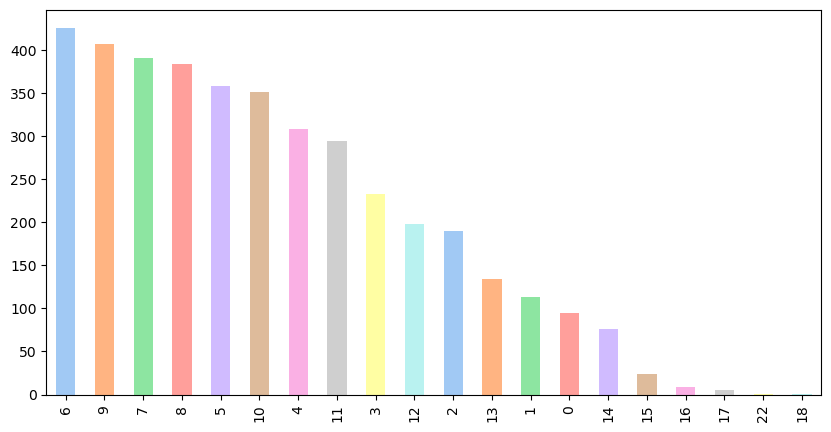

In [193]:
plt.figure(figsize=(10,5))
raw_data_sub['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [174]:
raw_data_sub['char_count'] = raw_data_sub['Correct_text'].apply(lambda x:len(''.join(str(x).split())))
raw_data_sub.head()

Annotation  oh_label                                       Correct_text  \
0       none       0.0                         ok done mole got outrag mr   
1       none       0.0                                       see thread p   
2     sexism       1.0        call exist watch women stand ball inch band   
3     racism       1.0          peopl leav slam announc quietli walk away   
4       none       0.0  sum hero baghdadi men rape women everi singl d...   

   word_count  char_count  
0           6          21  
1           3          10  
2           8          36  
3           7          35  
4          14          65

In [282]:
(raw_data_sub['char_count']==0).sum()

0

In [242]:
(raw_data_sub['word_count']==0).sum()

95

In [243]:
raw_data_sub.loc[raw_data_sub['char_count']==0]

Annotation  oh_label Correct_text  word_count  char_count
7          none       0.0                        0           0
52         none       0.0                        0           0
64         none       0.0                        0           0
78         none       0.0                        0           0
90         none       0.0                        0           0
108        none       0.0                        0           0
127        none       0.0                        0           0
145        none       0.0                        0           0
153        none       0.0                        0           0
169        none       0.0                        0           0
207        none       0.0                        0           0
212        none       0.0                        0           0
324        none       0.0                        0           0
418        none       0.0                        0           0
501        none       0.0                        0           0
506        none       0.0                        0           0
555        none       0.0                        0           0
625        none       0.0                        0           0
675        none       0.0                        0           0
701        none       0.0                        0           0
769        none       0.0                        0           0
844        none       0.0                        0           0
890        none       0.0                        0           0
946        none       0.0                        0           0
983        none       0.0                        0           0
992        none       0.0                        0           0
1098       none       0.0                        0           0
1107       none       0.0                        0           0
1147       none       0.0                        0           0
1157       none       0.0                        0           0
1192       none       0.0                        0           0
1251       none       0.0                        0           0
1293       none       0.0                        0           0
1303       none       0.0                        0           0
1360       none       0.0                        0           0
1416       none       0.0                        0           0
1513       none       0.0                        0           0
1538       none       0.0                        0           0
1630       none       0.0                        0           0
1655       none       0.0                        0           0
1799       none       0.0                        0           0
1812       none       0.0                        0           0
1817       none       0.0                        0           0
1821       none       0.0                        0           0
1843       none       0.0                        0           0
1882       none       0.0                        0           0
1908       none       0.0                        0           0
1933       none       0.0                        0           0
1978       none       0.0                        0           0
1989       none       0.0                        0           0
2003       none       0.0                        0           0
2017       none       0.0                        0           0
2090       none       0.0                        0           0
2175       none       0.0                        0           0
2178       none       0.0                        0           0
2230       none       0.0                        0           0
2267       none       0.0                        0           0
2297       none       0.0                        0           0
2305     sexism       1.0                        0           0
2390       none       0.0                        0           0
2460       none       0.0                        0           0
2481       none       0.0                        0           0
2491       none       0.0           

In [280]:
raw_data_sub = raw_data_sub.drop(labels=raw_data_sub[(raw_data_sub['char_count']==0)].index)

In [288]:
raw_data_sub = raw_data_sub.reset_index(drop=True)

In [281]:
raw_data_sub.shape

(3905, 5)

<AxesSubplot:>

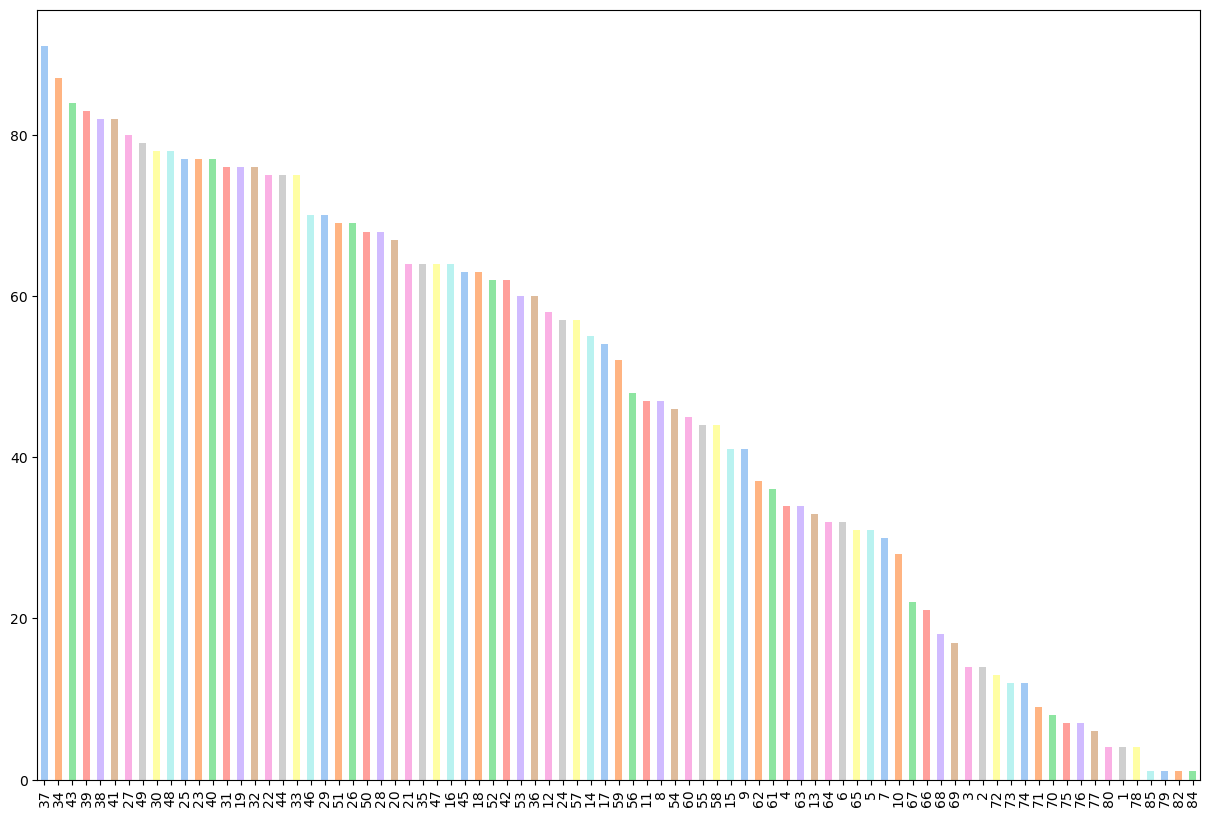

In [289]:
plt.figure(figsize=(15,10))
raw_data_sub['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [292]:
def avg_chars(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
raw_data_sub['avg_char'] = raw_data_sub['Correct_text'].apply(lambda x:avg_chars(x)).round(1)
raw_data_sub.head(5)

Annotation  oh_label                                       Correct_text  \
0       none       0.0                         ok done mole got outrag mr   
1       none       0.0                                       see thread p   
2     sexism       1.0        call exist watch women stand ball inch band   
3     racism       1.0          peopl leav slam announc quietli walk away   
4       none       0.0  sum hero baghdadi men rape women everi singl d...   

   word_count  char_count  avg_letters  avg_char  
0           6          21          3.5       3.5  
1           3          10          3.3       3.3  
2           8          36          4.5       4.5  
3           7          35          5.0       5.0  
4          14          65          4.6       4.6

In [293]:
raw_data_sub = raw_data_sub.drop(columns='avg_letters')
raw_data_sub.head(5)

Annotation  oh_label                                       Correct_text  \
0       none       0.0                         ok done mole got outrag mr   
1       none       0.0                                       see thread p   
2     sexism       1.0        call exist watch women stand ball inch band   
3     racism       1.0          peopl leav slam announc quietli walk away   
4       none       0.0  sum hero baghdadi men rape women everi singl d...   

   word_count  char_count  avg_char  
0           6          21       3.5  
1           3          10       3.3  
2           8          36       4.5  
3           7          35       5.0  
4          14          65       4.6

In [296]:
raw_data_sub = raw_data_sub.drop(columns='Annotation')
raw_data_sub.head(5)

oh_label                                       Correct_text  word_count  \
0       0.0                         ok done mole got outrag mr           6   
1       0.0                                       see thread p           3   
2       1.0        call exist watch women stand ball inch band           8   
3       1.0          peopl leav slam announc quietli walk away           7   
4       0.0  sum hero baghdadi men rape women everi singl d...          14   

   char_count  avg_char  
0          21       3.5  
1          10       3.3  
2          36       4.5  
3          35       5.0  
4          65       4.6

<AxesSubplot:>

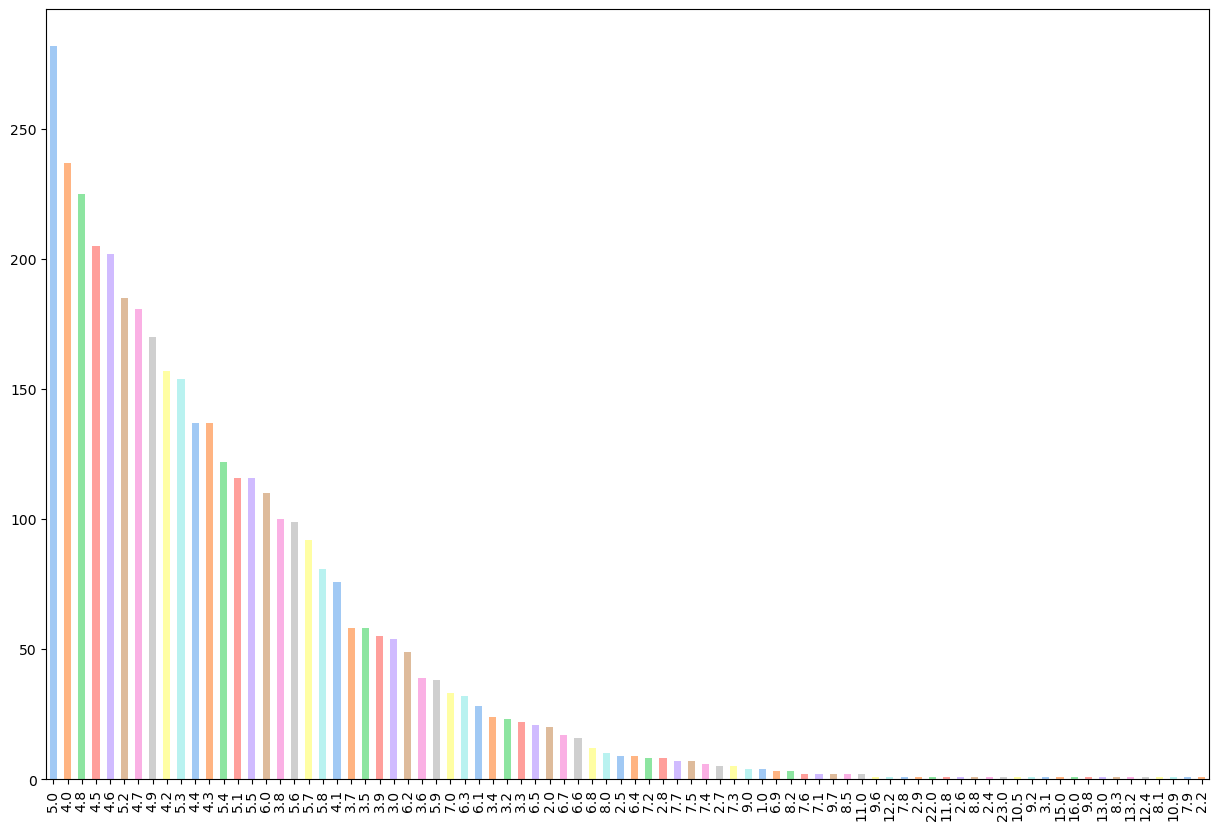

In [295]:
plt.figure(figsize=(15,10))
raw_data_sub['avg_char'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

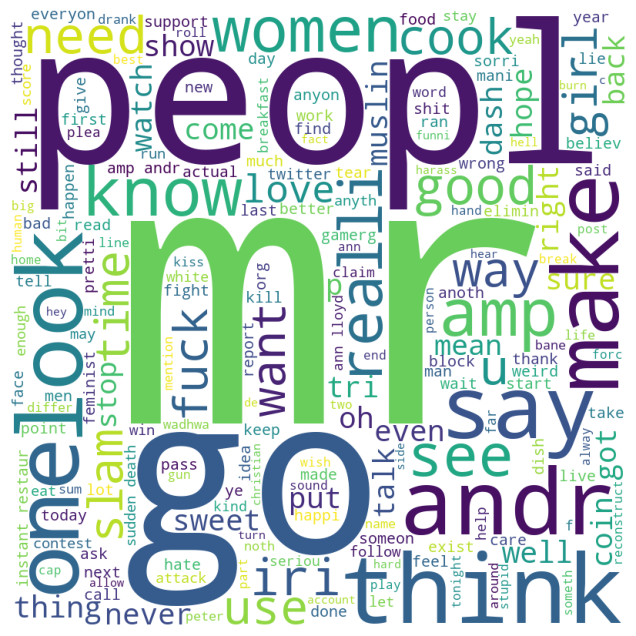

In [300]:
g = str(raw_data_sub[raw_data_sub['oh_label']==0]['Correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

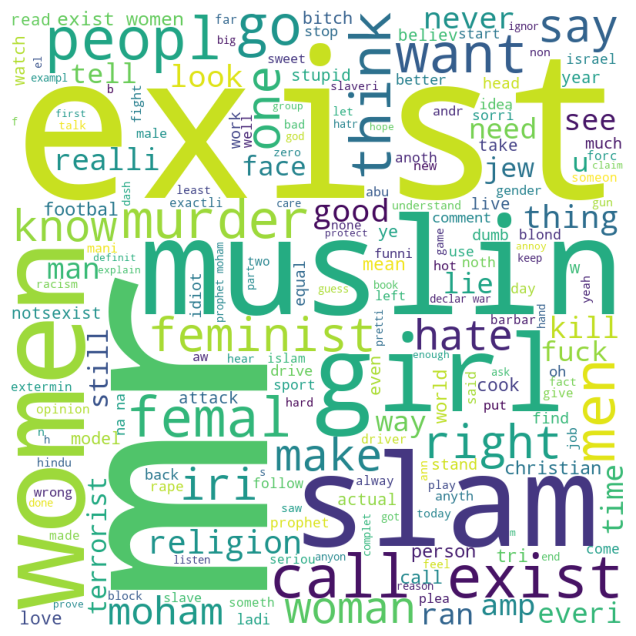

In [301]:
g = str(raw_data_sub[raw_data_sub['oh_label']==1]['Correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [382]:
X = raw_data_sub.drop(columns=['oh_label'])
y = raw_data_sub['oh_label']
Z = raw_data_sub.drop(columns=['Correct_text', 'oh_label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [383]:
Z_train = X_train.drop(columns='Correct_text')
Z_test = X_test.drop(columns='Correct_text')

X_train = X_train['Correct_text']
X_test = X_test['Correct_text']

x -> text   
y-> target       
z -> other numerical features       

In [384]:
X_train.shape

(3124,)

In [385]:
Z_train.head(5)

word_count  char_count  avg_char
707           13          67       5.2
1402          11          63       5.7
2360           8          35       4.4
3066           8          34       4.2
2861           7          33       4.7

In [1144]:
#Using BOW
bow = CountVectorizer(max_features=1000)

In [1145]:
X_train_vect1 = bow.fit_transform(X_train)
X_test_vect1 = bow.transform(X_test)

In [1146]:
X_train_vect1

<3124x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 16909 stored elements in Compressed Sparse Row format>

In [1147]:
X_train_bow = pd.DataFrame(X_train_vect1.toarray(),columns=bow.get_feature_names_out())
X_test_bow = pd.DataFrame(X_test_vect1.toarray(),columns=bow.get_feature_names_out())

In [1148]:
X_train_bow.head()

abl  abort  abu  accept  account  accur  act  action  activ  actual  ad  \
0    0      0    0       0        0      0    0       0      0       0   0   
1    0      0    0       0        0      0    0       0      0       0   0   
2    0      0    0       0        0      0    0       0      0       0   0   
3    0      0    0       0        0      0    0       0      0       0   0   
4    0      0    0       0        0      0    0       0      0       0   0   

   adam  admit  adult  advanc  age  ago  agr  ah  ahahah  ahead  air  al  \
0     0      0      0       0    0    0    0   0       0      0    0   0   
1     0      0      0       0    0    0    0   0       0      0    0   0   
2     0      0      0       0    0    0    0   0       0      0    0   0   
3     0      0      0       0    0    0    0   0       0      0    0   0   
4     0      0      0       0    0    0    0   0       0      0    0   0   

   aliv  allah  alli  allow  almost  alon  along  alreadi  also  alway  amaz  \
0     0      0     0      0       0     0      0        0     0      0     0   
1     0      0     0      0       0     0      0        0     0      0     0   
2     0      0     0      0       0     0      0        0     0      0     0   
3     0      0     0      0       0     0      0        0     0      0     0   
4     0      0     0      0       0     0      0        0     0      0     0   

   america  american  amount  amp  amu  analysi  andr  anim  ann  anna  \
0        0         0       0    0    0        0     0     0    0     0   
1        0         0       0    0    0        0     0     0    0     0   
2        0         0       0    1    0        0     1     0    0     0   
3        0         0       0    0    0        0     0     0    0     0   
4        0         0       0    0    0        0     0     0    0     0   

   announc  annoy  anoth  answer  anti  anymor  anyon  anyth  anyway  appar  \
0        0      0      0       0     0       0      0      0       0      0   
1        0      0      0       0     0       0      0      0       0      0   
2        0      0      0       0     0       0      0      0       0      0   
3        0      0      0       0     0       0      1      0       0      0   
4        0      0      0       0     0       0      0      0       0      0   

   appreci  approv  arab  area  argu  arm  around  articl  ash  ashor  ask  \
0        0       0     0     0     0    0       0       0    0      0    0   
1        0       0     0     0     0    0       0       0    0      0    0   
2        0       0     0     0     0    0       0       0    0      0    0   
3        0       0     0     0     0    0       0       0    0      0    0   
4        0       0     0     0     0    0       0       0    0      0    0   

   ass  atheist  attack  attitud  aw  awar  away  awesom  axilla  babi  back  \
0    0        0       0        0   0     0     0       0       0     0     0   
1    0        0       0        0   0     0     0       0       0     0     0   
2    0        0       0        0   0     0     0       0       0     0     0   
3    0        0       0        0   0     0     0       0       0     0     0   
4    0        0       0        0   1     0     0       0       0     0     0   

   backward  bacon  bad  bag  baghdadi  bake  ball  bane  banker  barbar  \
0         0      0    0    0         0     0     0     0       0       0   
1         0      0    0    0         0     0     0     0       0       0   
2         0      0    0    0         0     0     0     0       0       0   
3         0      0    0    0         0     0     0     0       0       0   
4         0      0    0    0         0     0     0     0       0       0   

   bare  base  basic  battl  beat  becom  bed  begin  behead  behind  believ  \
0     0     0      0      0     0      0    0      0       0       0       0   
1     0     0      0      0     0      0    0      0       0       0       0   
2     0     0      0      0  

In [1149]:
X_train_bow.shape

(3124, 1000)

In [1150]:
X_train_bow_c = pd.concat([X_train_bow, Z_train.reset_index(drop=True)], axis=1)
X_test_bow_c = pd.concat([X_test_bow, Z_test.reset_index(drop=True)], axis=1)

In [1151]:
X_train_bow_c.shape

(3124, 1003)

In [1152]:
X_test_bow_c.shape

(781, 1003)

In [1153]:
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_bow_c, y_train)
# X_train_resampled.shape:-->(4190, 503)

In [1154]:
kfold1 = KFold(n_splits=5, shuffle=True, random_state=42)
results1 = cross_val_score(clf1, X_train_bow_c, y_train, cv=kfold,scoring = 'accuracy')
results1.mean()

0.8034615384615386

In [1155]:
clf1 = RandomForestClassifier()
clf1.fit(X_train_bow_c, y_train)
pred1 = clf1.predict(X_test_bow_c)

In [1156]:
print("logloss: %0.3f " % log_loss(y_test.values, pred1))
print("Accuracy: %0.3f " % accuracy_score(y_test.values, pred1))

logloss: 7.341 
Accuracy: 0.787 


In [1175]:
#Using TFIDF
tfidf = TfidfVectorizer(max_features=4000)
X_train_vect2 = tfidf.fit_transform(X_train)
X_test_vect2 = tfidf.transform(X_test)

X_train_tfidf = pd.DataFrame(X_train_vect2.toarray(),columns=tfidf.get_feature_names_out())
X_test_tfidf = pd.DataFrame(X_test_vect2.toarray(),columns=tfidf.get_feature_names_out())

X_train_tfidf.head()

aaaaargh  aaaand  abb  abbott  abc  abdic  abil  abl  ablest  abnorm  \
0       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
1       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
2       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
3       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
4       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   

   abort  abraham  abrog  absent  absolut  absurd  abu  academ  accel  accent  \
0    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
1    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
2    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
3    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
4    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   

   accept  accessori  accid  accommod  accomplish  accord  accordingli  \
0     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
1     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
2     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
3     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
4     0.0        0.0    0.0       0.0         0.0     0.0          0.0   

   account  accu  accur  across  act  action  activ  activist  actor  actual  \
0      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
1      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
2      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
3      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
4      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   

    ad  adam  add  addit  address  adduct  adept  adjust  admir  admit  adopt  \
0  0.0   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0    0.0   
1  0.0   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0    0.0   
2  0.0   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0    0.0   
3  0.0   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0    0.0   
4  0.0   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0    0.0   

   ador  adult  adulteri  advanc  advantag  advi  advic  \
0   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
1   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
2   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
3   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
4   0.0    0.0       0.0     0.0       0.0   0.0    0.0   

   adviceforyoungfeminist  advoc  afar  affair  affect  affirm  afford  \
0                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
1                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
2                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
3                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
4                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   

   afghan  afghanistan  afraid  african  aftermath  afternoon  age  agenda  \
0     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
1     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
2     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
3     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
4     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   

   agent  aggress  agit  ago  agr  agradehang  agrafena  agreement   ah  \
0    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
1    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
2    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
3    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
4    0.0

In [1176]:
X_test_tfidf.head()

aaaaargh  aaaand  abb  abbott  abc  abdic  abil  abl  ablest  abnorm  \
0       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
1       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
2       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
3       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   
4       0.0     0.0  0.0     0.0  0.0    0.0   0.0  0.0     0.0     0.0   

   abort  abraham  abrog  absent  absolut  absurd  abu  academ  accel  accent  \
0    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
1    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
2    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
3    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   
4    0.0      0.0    0.0     0.0      0.0     0.0  0.0     0.0    0.0     0.0   

   accept  accessori  accid  accommod  accomplish  accord  accordingli  \
0     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
1     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
2     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
3     0.0        0.0    0.0       0.0         0.0     0.0          0.0   
4     0.0        0.0    0.0       0.0         0.0     0.0          0.0   

   account  accu  accur  across  act  action  activ  activist  actor  actual  \
0      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
1      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
2      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
3      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   
4      0.0   0.0    0.0     0.0  0.0     0.0    0.0       0.0    0.0     0.0   

         ad  adam  add  addit  address  adduct  adept  adjust  admir  admit  \
0  0.000000   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0   
1  0.000000   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0   
2  0.000000   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0   
3  0.647569   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0   
4  0.000000   0.0  0.0    0.0      0.0     0.0    0.0     0.0    0.0    0.0   

   adopt  ador  adult  adulteri  advanc  advantag  advi  advic  \
0    0.0   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
1    0.0   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
2    0.0   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
3    0.0   0.0    0.0       0.0     0.0       0.0   0.0    0.0   
4    0.0   0.0    0.0       0.0     0.0       0.0   0.0    0.0   

   adviceforyoungfeminist  advoc  afar  affair  affect  affirm  afford  \
0                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
1                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
2                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
3                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   
4                     0.0    0.0   0.0     0.0     0.0     0.0     0.0   

   afghan  afghanistan  afraid  african  aftermath  afternoon  age  agenda  \
0     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
1     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
2     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
3     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   
4     0.0          0.0     0.0      0.0        0.0        0.0  0.0     0.0   

   agent  aggress  agit  ago  agr  agradehang  agrafena  agreement   ah  \
0    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
1    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
2    0.0      0.0   0.0  0.0  0.0         0.0       0.0        0.0  0.0   
3    0.0      0.0   0.0  0.0  0.0         0.0       0

In [1177]:
X_train_tfidf_c = pd.concat([X_train_tfidf, Z_train.reset_index(drop=True)], axis=1)
X_test_tfidf_c = pd.concat([X_test_tfidf, Z_test.reset_index(drop=True)], axis=1)

print(X_train_tfidf_c.shape)
print(X_test_tfidf_c.shape)

(3124, 4003)
(781, 4003)


In [1278]:
clf2 = RandomForestClassifier()

kfold2 = KFold(n_splits=5, shuffle=True, random_state=42)
results2 = cross_val_score(clf2, X_train_tfidf_c, y_train, cv=kfold,scoring = 'accuracy')
results2.mean()

0.7996189743589743

In [1279]:
clf2.fit(X_train_tfidf_c, y_train)
pred2 = clf2.predict(X_test_tfidf_c)

In [1280]:
print("logloss: %0.3f " % log_loss(y_test.values, pred2))
print("Accuracy: %0.3f " % accuracy_score(y_test.values, pred2))

logloss: 6.722 
Accuracy: 0.805 


In [1723]:
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self,corpus, size):
        self.corpus=corpus
        self.size=size
#         pass
    
    def w2v(self):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in self.corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, vector_size=self.size, min_count=1)
        
        return self.w2v
    
    def transform(self):
        
        array_wordEmbed = []
        for sent in self.corpus:
            vec = np.zeros(self.size).reshape((1, self.size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,self.size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [1724]:
len(X['Correct_text'])

3905

In [1733]:
wv = Word_to_Vect(corpus = [sent for sent in X['Correct_text']], size = len(X['Correct_text']))
wv.w2v()

In [1734]:
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self):
        pass
    
    def w2v(self, corpus, size):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, vector_size=size, min_count=1)
        
        return self.w2v
    
    def transform(self, X_corpus, size):
        
        array_wordEmbed = []
        for sent in X_corpus:
            vec = np.zeros(size).reshape((1, size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [1735]:
w2v = Word_to_Vect().w2v(corpus = [sent for sent in X['Correct_text']], size = len(X['Correct_text']))

In [1736]:
w2v.wv.similar_by_vector('bad')

[('mr', 0.9964607357978821),
 ('like', 0.9963881969451904),
 ('peopl', 0.996330976486206),
 ('muslin', 0.9963204860687256),
 ('go', 0.996310830116272),
 ('amp', 0.9963098764419556),
 ('get', 0.9963095784187317),
 ('one', 0.9962915182113647),
 ('make', 0.9962557554244995),
 ('would', 0.9962530732154846)]

In [1738]:
X_w2v = pd.DataFrame({word:w2v.wv[word] for sent in X['Correct_text'] for word in sent.split()})
X_w2v.head()

ok      done      mole       got    outrag        mr       see  \
0  0.000410  0.002256  0.000139  0.002657  0.000219  0.009638  0.005284   
1 -0.000984 -0.003017 -0.000248 -0.004043 -0.000485 -0.014209 -0.008026   
2  0.000088  0.001106  0.000021  0.001327  0.000217  0.004804  0.002487   
3 -0.000674 -0.002333 -0.000305 -0.003039 -0.000286 -0.009728 -0.005739   
4 -0.001019 -0.003393 -0.000770 -0.004371 -0.000698 -0.015542 -0.008736   

     thread         p      call     exist     watch     women     stand  \
0  0.000388  0.001154  0.004271  0.006908  0.002617  0.005862  0.001352   
1 -0.000034 -0.002071 -0.006646 -0.010311 -0.004458 -0.008492 -0.001658   
2  0.000215  0.000750  0.001983  0.002978  0.001526  0.002619  0.000548   
3 -0.000087 -0.001435 -0.004828 -0.007346 -0.002867 -0.005942 -0.001155   
4 -0.000419 -0.002132 -0.007192 -0.010906 -0.004298 -0.008836 -0.001787   

       ball      inch      band     peopl      leav      slam   announc  \
0  0.000068  0.000046  0.000074  0.006542  0.001616  0.005739  0.000596   
1 -0.000203  0.000084 -0.000331 -0.009380 -0.002169 -0.008851 -0.000828   
2  0.000127  0.000069 -0.000166  0.002812  0.000502  0.002524  0.000207   
3 -0.000135 -0.000345 -0.000304 -0.006355 -0.001607 -0.006254 -0.000832   
4 -0.000367 -0.000058 -0.000371 -0.010150 -0.002237 -0.009312 -0.000937   

    quietli      walk      away       sum      hero  baghdadi       men  \
0  0.000139  0.000850  0.001093  0.001629  0.000436  0.001062  0.005740   
1 -0.000331 -0.001384 -0.001510 -0.002577 -0.000839 -0.001448 -0.008166   
2  0.000345  0.000572  0.000423  0.000718  0.000414  0.000526  0.002435   
3 -0.000145 -0.000698 -0.000989 -0.001861 -0.000609 -0.001211 -0.005838   
4 -0.000428 -0.001447 -0.001450 -0.002377 -0.000837 -0.001352 -0.009142   

       rape     everi     singl       day   western    coalit      forc  \
0  0.001210  0.003297  0.000546  0.003536  0.000387  0.000458  0.002360   
1 -0.001877 -0.004949 -0.001218 -0.005010 -0.000737 -0.000640 -0.003278   
2  0.000677  0.001488  0.000189  0.001552  0.000449  0.000407  0.000892   
3 -0.001637 -0.003444 -0.000774 -0.003270 -0.000405 -0.000564 -0.002382   
4 -0.002135 -0.005418 -0.001329 -0.005446 -0.000827 -0.000312 -0.003249   

       mani      year       ann  reaction     lloyd      said    dinner  \
0  0.002266  0.004167  0.002383  0.000351  0.001664  0.002078  0.000688   
1 -0.003294 -0.005979 -0.003374 -0.000311 -0.002321 -0.003097 -0.000983   
2  0.001277  0.002070  0.000820  0.000093  0.000689  0.001217  0.000280   
3 -0.002167 -0.004233 -0.002263 -0.000265 -0.001540 -0.002055 -0.000359   
4 -0.003496 -0.006265 -0.003313 -0.000190 -0.002394 -0.003350 -0.000896   

       land      hate    obviou     blond      limb      make    better  \
0  0.000743  0.003434  0.000918  0.000583  0.000138  0.005891  0.002781   
1 -0.001046 -0.004849 -0.001107 -0.001286 -0.000319 -0.008502 -0.004030   
2  0.000616  0.001572  0.000304  0.000419 -0.000041  0.002547  0.001624   
3 -0.000589 -0.003405 -0.000791 -0.000722 -0.000327 -0.005792 -0.003130   
4 -0.001462 -0.005169 -0.001470 -0.001142 -0.000506 -0.008980 -0.004708   

     accord   channel      shit      cook      andr      must      feel  \
0  0.000404  0.000525  0.002398  0.005095  0.004473  0.002065  0.002807   
1 -0.000437 -0.000726 -0.003150 -0.007135 -0.006762 -0.003244 -0.004161   
2  0.000111  0.000028  0.000977  0.002272  0.002038  0.000758  0.001478   
3 -0.000216 -0.000206 -0.002554 -0.005300 -0.004802 -0.002250 -0.003062   
4 -0.000304 -0.000690 -0.003733 -0.007951 -0.007263 -0.003471 -0.004610   

          f     stage    realli    matter       say    moment      busi  \
0  0.000381  0.000485  0.004081  0.000683  0.004802  0.000253  0.000706   
1 -0.000447 -0.000477 -0.006536 -0.000881 -0.006884 -0.000341 -0.001174   
2 -0.000132  0.000218  0.002123  0.000171  0.002502  0.000158  0.000362   
3 -0.000495 -0.000331 -0.004346 -0.000663 -0.004913 -0.000249 -0.000747   
4 -0.000357 -0.000751 -0.0

In [1739]:
x_t1, x_t2, _, _ = train_test_split(X_w2v, y, test_size=0.20, random_state=101)

In [1740]:
x_train = pd.concat([x_t1.reset_index(drop=True), Z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2.reset_index(drop=True), Z_test.reset_index(drop=True)], axis=1)

In [1741]:
clf = XGBClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [1742]:
print("logloss: %0.3f " % log_loss(y_test.values, pred))

logloss: 12.338 


In [1743]:
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(x_train.shape[1])

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 50)                236300    
                                                                 
 dense_225 (Dense)           (None, 1)                 51        
                                                                 
Total params: 236,351
Trainable params: 236,351
Non-trainable params: 0
_________________________________________________________________


In [1744]:
model.fit(np.asarray(x_train), np.asarray(y_train), epochs=50, batch_size=50)
# evaluate
loss, acc = model.evaluate(np.asarray(x_test), np.asarray(y_test))
print('Test Accuracy: %f' % (acc*100))

Epoch 1/50
63/63 [==============================] - 1s 4ms/step - loss: 0.6534 - accuracy: 0.6649
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 0.6315 - accuracy: 0.6697
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6703
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6655
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6639
Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6684
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 0.6193 - accuracy: 0.6703
Epoch 8/50
63/63 [==============================] - 0s 5ms/step - loss: 0.6192 - accuracy: 0.6687
Epoch 9/50
63/63 [==============================] - 0s 5ms/step - loss: 0.6163 - accuracy: 0.6645
Epoch 10/50
63/63 [==============================] - 0s 8ms/step - loss: 0.6144 - accuracy: 0.6687
Epoch 11/50
63/63 [

In [1746]:
y_pred_dl = model.predict(np.asarray(x_test))

print("logloss: %0.3f " % log_loss(y_test, y_pred_dl.round(), eps=1e-7))

25/25 [==============================] - 0s 2ms/step
logloss: 5.150 


In [1636]:
#Using Word2vec
tokens = [nltk.word_tokenize(sent) for sent in X_train]
w2v_model = Word2Vec(tokens,vector_size=1000,window=10,epochs=30)

In [1637]:
w2v_model.wv.most_similar('good')

[('keep', 0.9965193271636963),
 ('probabl', 0.9960274696350098),
 ('horribl', 0.9955611824989319),
 ('mmm', 0.9954921007156372),
 ('bacon', 0.9952614307403564),
 ('mad', 0.9948250651359558),
 ('shut', 0.9948158264160156),
 ('definit', 0.9946057796478271),
 ('snug', 0.9945810437202454),
 ('minut', 0.9945300221443176)]

In [1638]:
w2v_model.wv['bad']

array([ 1.15696132e-01,  3.13413031e-02,  4.93820608e-02,  4.11959775e-02,
       -3.67003120e-02, -1.02175996e-02,  1.21809710e-02,  5.99500015e-02,
       -2.15614755e-02,  1.28989704e-02,  6.77649006e-02,  3.49036828e-02,
       -2.40716077e-02,  5.10165095e-03,  1.41832501e-01, -3.01068323e-03,
       -4.08590920e-02,  1.31049491e-02,  6.30192757e-02, -1.48083210e-01,
        4.29983176e-02, -8.96740109e-02,  2.66772509e-02, -1.93542596e-02,
        8.14775378e-02, -3.95287499e-02,  6.95169419e-02, -6.60075340e-03,
       -1.99469939e-01,  5.10328114e-02,  4.16809618e-02, -5.42012341e-02,
       -7.45747164e-02, -3.63218896e-02,  4.68397923e-02, -4.24671732e-02,
        5.18399589e-02,  1.58352382e-03, -2.32945997e-02, -1.19070478e-01,
       -1.16650704e-02,  1.92245655e-02, -8.43530074e-02,  6.72864914e-02,
        9.55428742e-03, -3.04385275e-02, -6.92298785e-02,  7.89866894e-02,
       -8.16393793e-02,  6.17001466e-02, -3.21654752e-02, -2.48538293e-02,
        1.89551234e-03, -

In [1639]:
def w2v_embed(text, model):
    words = text.split()
    rows = []
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        rows.append(np.mean(embeddings, axis=0))
    else:
        rows.append(np.zeros(model.vector_size))
    
    return pd.DataFrame(data=rows)

#     embeds = []
#     for word in words:
#         if word in model.wv:
#             embeds.append(model.wv[word])
#         else:
#             embeds.append(np.zeros(model.vector_size))
#     return embeds

In [1640]:
# X_train_w2v = X_train.apply(lambda x:w2v_embed(x,w2v_model))

In [1641]:
X_train_w2v = pd.DataFrame()
for i_1 in X_train:
    d_1 = w2v_embed(i_1,w2v_model)
    X_train_w2v = pd.concat([X_train_w2v, d_1], axis=0)

In [1642]:
X_train_w2v = X_train_w2v.reset_index(drop=True)

In [1643]:
X_test_w2v = pd.DataFrame()
for i_2 in X_test:
    d_2 = w2v_embed(i_2,w2v_model)
    X_test_w2v = pd.concat([X_test_w2v, d_2], axis=0)

In [1644]:
X_test_w2v = X_test_w2v.reset_index(drop=True)

In [1645]:
X_train_w2v.head()

0         1         2         3         4         5         6    \
0  0.094680 -0.020298  0.037868 -0.003244 -0.055230 -0.007152  0.054936   
1  0.119537  0.030083  0.043224  0.052936 -0.043979 -0.013809  0.025535   
2  0.156952  0.083288  0.053202  0.161134 -0.028033 -0.033673  0.010232   
3  0.110664  0.024636  0.049893  0.028292 -0.041210 -0.008540  0.015129   
4  0.151536  0.058070  0.081416  0.013923 -0.044047  0.003392 -0.015897   

        7         8         9         10        11        12        13   \
0  0.061564  0.035680  0.036834  0.136192  0.045557 -0.011068 -0.030711   
1  0.052722 -0.040007  0.022444  0.056363  0.031574 -0.017508 -0.002413   
2  0.032666 -0.163474  0.028455 -0.030334 -0.009902 -0.036347  0.010351   
3  0.060045 -0.014113  0.008336  0.069832  0.044686 -0.020023  0.000304   
4  0.078059  0.002019 -0.031080  0.049236  0.087909 -0.024389  0.024982   

        14        15        16        17        18        19        20   \
0  0.189651 -0.034516 -0.065006 -0.023286  0.016123 -0.135573  0.058938   
1  0.142893  0.001510 -0.035254  0.015298  0.057784 -0.152109  0.040279   
2  0.137417  0.061089  0.011072  0.065752  0.119734 -0.209662  0.052041   
3  0.131668 -0.010994 -0.045380  0.007461  0.052926 -0.133468  0.036984   
4  0.073055 -0.026435 -0.059552  0.021345  0.082286 -0.138250  0.007199   

        21        22        23        24        25        26        27   \
0 -0.100419  0.048858  0.007698  0.063690 -0.027451  0.013668 -0.049685   
1 -0.094683  0.010433 -0.016873  0.074435 -0.025409  0.075419  0.002963   
2 -0.127137 -0.044922 -0.018323  0.099118 -0.029669  0.154074  0.071788   
3 -0.080882  0.031654 -0.023299  0.072629 -0.030652  0.058464 -0.011007   
4 -0.058580  0.047993 -0.059971  0.085437 -0.033613  0.090349  0.006460   

        28        29        30        31        32        33        34   \
0 -0.196040  0.068008  0.126983 -0.050172 -0.053942 -0.027987  0.068404   
1 -0.194940  0.042576  0.031210 -0.049619 -0.075181 -0.038459  0.036607   
2 -0.218148  0.020372 -0.097396 -0.071074 -0.096516 -0.050433  0.013978   
3 -0.187992  0.050705  0.053249 -0.039190 -0.070137 -0.033634  0.044006   
4 -0.202055  0.058090  0.039693 -0.009612 -0.092276 -0.041776  0.033709   

        35        36        37        38        39        40        41   \
0 -0.009670  0.060525  0.048349 -0.033847 -0.083583 -0.014898 -0.058941   
1 -0.038787  0.040280  0.024649 -0.008656 -0.136815 -0.014780  0.010248   
2 -0.067470  0.039096  0.007403 -0.001634 -0.230207  0.004030  0.051273   
3 -0.042876  0.040963  0.013687 -0.014202 -0.112489 -0.016581  0.018520   
4 -0.065338  0.007852  0.002765  0.001192 -0.125882 -0.025795  0.099982   

        42        43        44        45        46        47        48   \
0 -0.110335  0.106770 -0.023110 -0.014794 -0.041987  0.074145 -0.074168   
1 -0.080480  0.071842  0.000297 -0.031071 -0.058348  0.080095 -0.056273   
2 -0.080820  0.054459 -0.032969 -0.042336 -0.075996  0.095773 -0.015808   
3 -0.079669  0.062411  0.019967 -0.035110 -0.064449  0.073294 -0.079149   
4 -0.063039  0.032641  0.091002 -0.052048 -0.078250  0.080249 -0.115458   

        49        50        51        52        53        54        55   \
0  0.026080  0.002669 -0.013770 -0.028431 -0.057474  0.030099 -0.004680   
1  0.064405 -0.032489 -0.013322  0.002789 -0.082557  0.041441 -0.015155   
2  0.113550 -0.069800 -0.008536  0.027362 -0.109345  0.062368 -0.051159   
3  0.058816 -0.027350 -0.024013  0.006832 -0.076348  0.027027 -0.010681   
4  0.078921 -0.037907 -0.026390  0.030694 -0.113014  0.043411  0.010033   

        56        57        58        59        60        61        62   \
0  0.027856  0.009441 -0.029191  0.032370 -0.040613 -0.001453 -0.061457   
1  0.075618 -0.015683 -0.081945  0.001047 -0.082256  0.008487 -0.064985   
2  0.150368 -0.030601 -0.170824 -0.058803 -0.115274  0.045215 -0.085793   
3  0.053371 -0.013825 -0.059379  0.010029 -0.081809 -0.011300 -0.054550   
4  0.074582 -0.040400 -0.

In [1646]:
X_test_w2v.head()

0         1         2         3         4         5         6    \
0  0.100393 -0.044915  0.051110 -0.053615 -0.073929 -0.002734  0.060330   
1  0.155823  0.072173  0.052451  0.127286 -0.035288 -0.026582  0.011166   
2  0.138384  0.059788  0.047709  0.112889 -0.034981 -0.024427  0.016318   
3  0.103378  0.017651  0.046867  0.017282 -0.041238 -0.005756  0.018278   
4  0.120723  0.016917  0.074313 -0.033425 -0.049386  0.004165 -0.010238   

        7         8         9         10        11        12        13   \
0  0.080083  0.091724  0.035845  0.182418  0.067081 -0.004723 -0.028317   
1  0.044503 -0.122366  0.019612 -0.010795  0.001205 -0.032730  0.007987   
2  0.045492 -0.108058  0.025794  0.012733  0.007275 -0.029806  0.005826   
3  0.055627  0.000197  0.010544  0.076035  0.042606 -0.016907 -0.001383   
4  0.078047  0.057077 -0.025947  0.094777  0.093227 -0.019146  0.008241   

        14        15        16        17        18        19        20   \
0  0.202968 -0.070970 -0.086484 -0.027197  0.018114 -0.152272  0.060899   
1  0.125719  0.045113 -0.004723  0.054642  0.095810 -0.186892  0.045247   
2  0.145705  0.035160 -0.012979  0.041754  0.088223 -0.182122  0.048969   
3  0.129042 -0.016224 -0.046313  0.002592  0.045310 -0.125386  0.035782   
4  0.101620 -0.053698 -0.076919 -0.005876  0.060019 -0.120870  0.016704   

        21        22        23        24        25        26        27   \
0 -0.106256  0.085194 -0.004380  0.073972 -0.037120 -0.004618 -0.086452   
1 -0.118927 -0.025495 -0.016675  0.089927 -0.022919  0.129930  0.049530   
2 -0.112594 -0.020213 -0.019050  0.089399 -0.028684  0.117468  0.038359   
3 -0.076062  0.034328 -0.018053  0.069029 -0.029922  0.051890 -0.016995   
4 -0.054372  0.079451 -0.054179  0.085006 -0.035821  0.038823 -0.030637   

        28        29        30        31        32        33        34   \
0 -0.230974  0.094470  0.179934 -0.036234 -0.054333 -0.027183  0.103978   
1 -0.207385  0.023090 -0.061103 -0.057410 -0.090904 -0.048242  0.026487   
2 -0.208180  0.029004 -0.035523 -0.064452 -0.088015 -0.046870  0.024108   
3 -0.179360  0.049871  0.060281 -0.035468 -0.064215 -0.029517  0.045864   
4 -0.203052  0.078666  0.100894 -0.010181 -0.075970 -0.030559  0.056532   

        35        36        37        38        39        40        41   \
0  0.000307  0.072900  0.060120 -0.050225 -0.061989 -0.040279 -0.067841   
1 -0.056467  0.032753  0.006118 -0.005221 -0.201515 -0.003643  0.043334   
2 -0.055001  0.042735  0.011152 -0.003531 -0.187864 -0.005759  0.034331   
3 -0.035092  0.038880  0.016798 -0.016182 -0.098396 -0.015756  0.011747   
4 -0.049023  0.027331  0.005933 -0.016244 -0.077743 -0.030993  0.059396   

        42        43        44        45        46        47        48   \
0 -0.145918  0.130656 -0.016583 -0.012297 -0.038321  0.063230 -0.114850   
1 -0.081363  0.062703 -0.019884 -0.043881 -0.063671  0.096793 -0.037814   
2 -0.079216  0.062470 -0.015699 -0.042454 -0.071005  0.094812 -0.035548   
3 -0.077708  0.065137  0.018469 -0.025874 -0.057041  0.066988 -0.077282   
4 -0.080483  0.048071  0.086353 -0.034617 -0.082774  0.068607 -0.134380   

        49        50        51        52        53        54        55   \
0  0.008599  0.008745 -0.023096 -0.043907 -0.083116  0.022383 -0.008949   
1  0.100886 -0.061931 -0.008754  0.022619 -0.104645  0.050268 -0.042214   
2  0.093874 -0.052680 -0.014816  0.016573 -0.094213  0.050348 -0.035161   
3  0.048722 -0.022527 -0.021268  0.004092 -0.073496  0.028412 -0.009296   
4  0.052077 -0.023909 -0.033849  0.013823 -0.094901  0.022215  0.005860   

        56        57        58        59        60        61        62   \
0  0.004928  0.011481 -0.000183  0.053035 -0.062935 -0.029022 -0.063825   
1  0.129800 -0.024261 -0.148419 -0.042567 -0.113000  0.026904 -0.079973   
2  0.111864 -0.023821 -0.128960 -0.031252 -0.097961  0.027818 -0.074303   
3  0.047648 -0.009051 -0.049571  0.014326 -0.073726 -0.009743 -0.054360   
4  0.030709 -0.019020 -0.

In [1647]:
X_train_w2v.shape

(3124, 1000)

In [1648]:
X_test_w2v.shape

(781, 1000)

In [1649]:
X_train_w2v_c = pd.concat([X_train_w2v, Z_train.reset_index(drop=True)], axis=1)
X_test_w2v_c = pd.concat([X_test_w2v, Z_test.reset_index(drop=True)], axis=1)

In [1650]:
X_train_w2v_c.head()

0         1         2         3         4         5         6  \
0  0.094680 -0.020298  0.037868 -0.003244 -0.055230 -0.007152  0.054936   
1  0.119537  0.030083  0.043224  0.052936 -0.043979 -0.013809  0.025535   
2  0.156952  0.083288  0.053202  0.161134 -0.028033 -0.033673  0.010232   
3  0.110664  0.024636  0.049893  0.028292 -0.041210 -0.008540  0.015129   
4  0.151536  0.058070  0.081416  0.013923 -0.044047  0.003392 -0.015897   

          7         8         9        10        11        12        13  \
0  0.061564  0.035680  0.036834  0.136192  0.045557 -0.011068 -0.030711   
1  0.052722 -0.040007  0.022444  0.056363  0.031574 -0.017508 -0.002413   
2  0.032666 -0.163474  0.028455 -0.030334 -0.009902 -0.036347  0.010351   
3  0.060045 -0.014113  0.008336  0.069832  0.044686 -0.020023  0.000304   
4  0.078059  0.002019 -0.031080  0.049236  0.087909 -0.024389  0.024982   

         14        15        16        17        18        19        20  \
0  0.189651 -0.034516 -0.065006 -0.023286  0.016123 -0.135573  0.058938   
1  0.142893  0.001510 -0.035254  0.015298  0.057784 -0.152109  0.040279   
2  0.137417  0.061089  0.011072  0.065752  0.119734 -0.209662  0.052041   
3  0.131668 -0.010994 -0.045380  0.007461  0.052926 -0.133468  0.036984   
4  0.073055 -0.026435 -0.059552  0.021345  0.082286 -0.138250  0.007199   

         21        22        23        24        25        26        27  \
0 -0.100419  0.048858  0.007698  0.063690 -0.027451  0.013668 -0.049685   
1 -0.094683  0.010433 -0.016873  0.074435 -0.025409  0.075419  0.002963   
2 -0.127137 -0.044922 -0.018323  0.099118 -0.029669  0.154074  0.071788   
3 -0.080882  0.031654 -0.023299  0.072629 -0.030652  0.058464 -0.011007   
4 -0.058580  0.047993 -0.059971  0.085437 -0.033613  0.090349  0.006460   

         28        29        30        31        32        33        34  \
0 -0.196040  0.068008  0.126983 -0.050172 -0.053942 -0.027987  0.068404   
1 -0.194940  0.042576  0.031210 -0.049619 -0.075181 -0.038459  0.036607   
2 -0.218148  0.020372 -0.097396 -0.071074 -0.096516 -0.050433  0.013978   
3 -0.187992  0.050705  0.053249 -0.039190 -0.070137 -0.033634  0.044006   
4 -0.202055  0.058090  0.039693 -0.009612 -0.092276 -0.041776  0.033709   

         35        36        37        38        39        40        41  \
0 -0.009670  0.060525  0.048349 -0.033847 -0.083583 -0.014898 -0.058941   
1 -0.038787  0.040280  0.024649 -0.008656 -0.136815 -0.014780  0.010248   
2 -0.067470  0.039096  0.007403 -0.001634 -0.230207  0.004030  0.051273   
3 -0.042876  0.040963  0.013687 -0.014202 -0.112489 -0.016581  0.018520   
4 -0.065338  0.007852  0.002765  0.001192 -0.125882 -0.025795  0.099982   

         42        43        44        45        46        47        48  \
0 -0.110335  0.106770 -0.023110 -0.014794 -0.041987  0.074145 -0.074168   
1 -0.080480  0.071842  0.000297 -0.031071 -0.058348  0.080095 -0.056273   
2 -0.080820  0.054459 -0.032969 -0.042336 -0.075996  0.095773 -0.015808   
3 -0.079669  0.062411  0.019967 -0.035110 -0.064449  0.073294 -0.079149   
4 -0.063039  0.032641  0.091002 -0.052048 -0.078250  0.080249 -0.115458   

         49        50        51        52        53        54        55  \
0  0.026080  0.002669 -0.013770 -0.028431 -0.057474  0.030099 -0.004680   
1  0.064405 -0.032489 -0.013322  0.002789 -0.082557  0.041441 -0.015155   
2  0.113550 -0.069800 -0.008536  0.027362 -0.109345  0.062368 -0.051159   
3  0.058816 -0.027350 -0.024013  0.006832 -0.076348  0.027027 -0.010681   
4  0.078921 -0.037907 -0.026390  0.030694 -0.113014  0.043411  0.010033   

         56        57        58        59        60        61        62  \
0  0.027856  0.009441 -0.029191  0.032370 -0.040613 -0.001453 -0.061457   
1  0.075618 -0.015683 -0.081945  0.001047 -0.082256  0.008487 -0.064985   
2  0.150368 -0.030601 -0.170824 -0.058803 -0.115274  0.045215 -0.085793   
3  0.053371 -0.013825 -0.059379  0.010029 -0.081809 -0.011300 -0.054550   
4  0.074582 -0.040400 -0.06

In [1651]:
X_test_w2v_c.head()

0         1         2         3         4         5         6  \
0  0.100393 -0.044915  0.051110 -0.053615 -0.073929 -0.002734  0.060330   
1  0.155823  0.072173  0.052451  0.127286 -0.035288 -0.026582  0.011166   
2  0.138384  0.059788  0.047709  0.112889 -0.034981 -0.024427  0.016318   
3  0.103378  0.017651  0.046867  0.017282 -0.041238 -0.005756  0.018278   
4  0.120723  0.016917  0.074313 -0.033425 -0.049386  0.004165 -0.010238   

          7         8         9        10        11        12        13  \
0  0.080083  0.091724  0.035845  0.182418  0.067081 -0.004723 -0.028317   
1  0.044503 -0.122366  0.019612 -0.010795  0.001205 -0.032730  0.007987   
2  0.045492 -0.108058  0.025794  0.012733  0.007275 -0.029806  0.005826   
3  0.055627  0.000197  0.010544  0.076035  0.042606 -0.016907 -0.001383   
4  0.078047  0.057077 -0.025947  0.094777  0.093227 -0.019146  0.008241   

         14        15        16        17        18        19        20  \
0  0.202968 -0.070970 -0.086484 -0.027197  0.018114 -0.152272  0.060899   
1  0.125719  0.045113 -0.004723  0.054642  0.095810 -0.186892  0.045247   
2  0.145705  0.035160 -0.012979  0.041754  0.088223 -0.182122  0.048969   
3  0.129042 -0.016224 -0.046313  0.002592  0.045310 -0.125386  0.035782   
4  0.101620 -0.053698 -0.076919 -0.005876  0.060019 -0.120870  0.016704   

         21        22        23        24        25        26        27  \
0 -0.106256  0.085194 -0.004380  0.073972 -0.037120 -0.004618 -0.086452   
1 -0.118927 -0.025495 -0.016675  0.089927 -0.022919  0.129930  0.049530   
2 -0.112594 -0.020213 -0.019050  0.089399 -0.028684  0.117468  0.038359   
3 -0.076062  0.034328 -0.018053  0.069029 -0.029922  0.051890 -0.016995   
4 -0.054372  0.079451 -0.054179  0.085006 -0.035821  0.038823 -0.030637   

         28        29        30        31        32        33        34  \
0 -0.230974  0.094470  0.179934 -0.036234 -0.054333 -0.027183  0.103978   
1 -0.207385  0.023090 -0.061103 -0.057410 -0.090904 -0.048242  0.026487   
2 -0.208180  0.029004 -0.035523 -0.064452 -0.088015 -0.046870  0.024108   
3 -0.179360  0.049871  0.060281 -0.035468 -0.064215 -0.029517  0.045864   
4 -0.203052  0.078666  0.100894 -0.010181 -0.075970 -0.030559  0.056532   

         35        36        37        38        39        40        41  \
0  0.000307  0.072900  0.060120 -0.050225 -0.061989 -0.040279 -0.067841   
1 -0.056467  0.032753  0.006118 -0.005221 -0.201515 -0.003643  0.043334   
2 -0.055001  0.042735  0.011152 -0.003531 -0.187864 -0.005759  0.034331   
3 -0.035092  0.038880  0.016798 -0.016182 -0.098396 -0.015756  0.011747   
4 -0.049023  0.027331  0.005933 -0.016244 -0.077743 -0.030993  0.059396   

         42        43        44        45        46        47        48  \
0 -0.145918  0.130656 -0.016583 -0.012297 -0.038321  0.063230 -0.114850   
1 -0.081363  0.062703 -0.019884 -0.043881 -0.063671  0.096793 -0.037814   
2 -0.079216  0.062470 -0.015699 -0.042454 -0.071005  0.094812 -0.035548   
3 -0.077708  0.065137  0.018469 -0.025874 -0.057041  0.066988 -0.077282   
4 -0.080483  0.048071  0.086353 -0.034617 -0.082774  0.068607 -0.134380   

         49        50        51        52        53        54        55  \
0  0.008599  0.008745 -0.023096 -0.043907 -0.083116  0.022383 -0.008949   
1  0.100886 -0.061931 -0.008754  0.022619 -0.104645  0.050268 -0.042214   
2  0.093874 -0.052680 -0.014816  0.016573 -0.094213  0.050348 -0.035161   
3  0.048722 -0.022527 -0.021268  0.004092 -0.073496  0.028412 -0.009296   
4  0.052077 -0.023909 -0.033849  0.013823 -0.094901  0.022215  0.005860   

         56        57        58        59        60        61        62  \
0  0.004928  0.011481 -0.000183  0.053035 -0.062935 -0.029022 -0.063825   
1  0.129800 -0.024261 -0.148419 -0.042567 -0.113000  0.026904 -0.079973   
2  0.111864 -0.023821 -0.128960 -0.031252 -0.097961  0.027818 -0.074303   
3  0.047648 -0.009051 -0.049571  0.014326 -0.073726 -0.009743 -0.054360   
4  0.030709 -0.019020 -0.02

In [1652]:
X_train_w2v_c.shape

(3124, 1003)

In [1653]:
X_test_w2v_c.shape

(781, 1003)

In [1654]:
X_train_w2v_c.isna().sum()

0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
30            0
31            0
32            0
33            0
34            0
35            0
36            0
37            0
38            0
39            0
40            0
41            0
42            0
43            0
44            0
45            0
46            0
47            0
48            0
49            0
50            0
51            0
52            0
53            0
54            0
55            0
56            0
57            0
58            0
59            0
60            0
61            0
62      

In [1655]:
X_test_w2v_c.isna().sum()

0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
30            0
31            0
32            0
33            0
34            0
35            0
36            0
37            0
38            0
39            0
40            0
41            0
42            0
43            0
44            0
45            0
46            0
47            0
48            0
49            0
50            0
51            0
52            0
53            0
54            0
55            0
56            0
57            0
58            0
59            0
60            0
61            0
62      

In [1656]:
clf3 = XGBClassifier()

In [1657]:
kfold3 = KFold(n_splits=5, shuffle=True, random_state=42)
results3 = cross_val_score(clf3, X_train_w2v_c, y_train, cv=kfold,scoring = 'accuracy',error_score='raise')
results3.mean()

0.7554528205128206

In [1658]:
clf3.fit(X_train_w2v_c, y_train)
pred3 = clf3.predict(X_test_w2v_c)

In [1659]:
print("logloss: %0.3f " % log_loss(y_test.values, pred3))
print("Accuracy: %0.3f " % accuracy_score(y_test.values, pred3))

logloss: 8.845 
Accuracy: 0.744 


In [1748]:
#Using Deep Learning
model = Sequential()
model.add(Dense(500, input_dim=1000, activation='relu'))
model.add(Dense(350, activation='relu'))
# model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
# model.add(Dense(150, activation='relu'))
model.add(Dense(60, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [1749]:
metrics = [
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_226 (Dense)           (None, 500)               500500    
                                                                 
 dense_227 (Dense)           (None, 350)               175350    
                                                                 
 dense_228 (Dense)           (None, 200)               70200     
                                                                 
 dense_229 (Dense)           (None, 60)                12060     
                                                                 
 dense_230 (Dense)           (None, 1)                 61        
                                                                 
Total params: 758,171
Trainable params: 758,171
Non-trainable params: 0
_________________________________________________________________


In [1750]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_w2v, y_train)

In [1751]:
# scaler = StandardScaler()
# X_train_scl = scaler.fit_transform(X_train_resampled)
# X_test_scl = scaler.transform(X_test_w2v)

In [1752]:
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=2)
history = model.fit(np.asarray(X_train_resampled), np.asarray(y_train_resampled),validation_data=(np.asarray(X_test_w2v),np.asarray(y_test)), epochs=100, batch_size=70)

Epoch 1/100
60/60 [==============================] - 2s 15ms/step - loss: 0.6159 - accuracy: 0.0000e+00 - precision: 0.7297 - recall: 0.5527 - auc_53: 0.7103 - val_loss: 0.6522 - val_accuracy: 0.0000e+00 - val_precision: 0.5138 - val_recall: 0.6350 - val_auc_53: 0.7206
Epoch 2/100
60/60 [==============================] - 1s 10ms/step - loss: 0.5997 - accuracy: 0.0000e+00 - precision: 0.7602 - recall: 0.5494 - auc_53: 0.7238 - val_loss: 0.5751 - val_accuracy: 0.0000e+00 - val_precision: 0.6685 - val_recall: 0.4601 - val_auc_53: 0.7208
Epoch 3/100
60/60 [==============================] - 1s 10ms/step - loss: 0.6032 - accuracy: 0.0000e+00 - precision: 0.7437 - recall: 0.5484 - auc_53: 0.7238 - val_loss: 0.6420 - val_accuracy: 0.0000e+00 - val_precision: 0.5107 - val_recall: 0.6350 - val_auc_53: 0.7243
Epoch 4/100
60/60 [==============================] - 1s 10ms/step - loss: 0.6067 - accuracy: 0.0000e+00 - precision: 0.7515 - recall: 0.5427 - auc_53: 0.7195 - val_loss: 0.6333 - val_accurac

60/60 [==============================] - 1s 14ms/step - loss: 0.5733 - accuracy: 0.0000e+00 - precision: 0.7601 - recall: 0.5838 - auc_53: 0.7557 - val_loss: 0.6290 - val_accuracy: 0.0000e+00 - val_precision: 0.5596 - val_recall: 0.5894 - val_auc_53: 0.7222
Epoch 32/100
60/60 [==============================] - 1s 14ms/step - loss: 0.5741 - accuracy: 0.0000e+00 - precision: 0.7688 - recall: 0.5795 - auc_53: 0.7532 - val_loss: 0.6259 - val_accuracy: 0.0000e+00 - val_precision: 0.5774 - val_recall: 0.5817 - val_auc_53: 0.7258
Epoch 33/100
60/60 [==============================] - 1s 17ms/step - loss: 0.5724 - accuracy: 0.0000e+00 - precision: 0.7756 - recall: 0.5742 - auc_53: 0.7580 - val_loss: 0.6171 - val_accuracy: 0.0000e+00 - val_precision: 0.5331 - val_recall: 0.6122 - val_auc_53: 0.7403
Epoch 34/100
60/60 [==============================] - 1s 13ms/step - loss: 0.5741 - accuracy: 0.0000e+00 - precision: 0.7700 - recall: 0.5737 - auc_53: 0.7541 - val_loss: 0.5771 - val_accuracy: 0.0000

60/60 [==============================] - 1s 12ms/step - loss: 0.5601 - accuracy: 0.0000e+00 - precision: 0.7668 - recall: 0.5947 - auc_53: 0.7708 - val_loss: 0.6108 - val_accuracy: 0.0000e+00 - val_precision: 0.5692 - val_recall: 0.5627 - val_auc_53: 0.7325
Epoch 62/100
60/60 [==============================] - 1s 13ms/step - loss: 0.5622 - accuracy: 0.0000e+00 - precision: 0.7882 - recall: 0.5842 - auc_53: 0.7734 - val_loss: 0.6085 - val_accuracy: 0.0000e+00 - val_precision: 0.5405 - val_recall: 0.6084 - val_auc_53: 0.7343
Epoch 63/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5611 - accuracy: 0.0000e+00 - precision: 0.7572 - recall: 0.6148 - auc_53: 0.7728 - val_loss: 0.5858 - val_accuracy: 0.0000e+00 - val_precision: 0.6033 - val_recall: 0.5551 - val_auc_53: 0.7350
Epoch 64/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5586 - accuracy: 0.0000e+00 - precision: 0.7865 - recall: 0.5838 - auc_53: 0.7742 - val_loss: 0.6052 - val_accuracy: 0.0000

60/60 [==============================] - 1s 17ms/step - loss: 0.5433 - accuracy: 0.0000e+00 - precision: 0.7801 - recall: 0.6301 - auc_53: 0.7909 - val_loss: 0.5866 - val_accuracy: 0.0000e+00 - val_precision: 0.6245 - val_recall: 0.5437 - val_auc_53: 0.7291
Epoch 92/100
60/60 [==============================] - 1s 20ms/step - loss: 0.5486 - accuracy: 0.0000e+00 - precision: 0.7745 - recall: 0.6081 - auc_53: 0.7832 - val_loss: 0.5854 - val_accuracy: 0.0000e+00 - val_precision: 0.5902 - val_recall: 0.5475 - val_auc_53: 0.7320
Epoch 93/100
60/60 [==============================] - 1s 20ms/step - loss: 0.5448 - accuracy: 0.0000e+00 - precision: 0.7862 - recall: 0.6038 - auc_53: 0.7896 - val_loss: 0.5846 - val_accuracy: 0.0000e+00 - val_precision: 0.5746 - val_recall: 0.5856 - val_auc_53: 0.7471
Epoch 94/100
60/60 [==============================] - 1s 25ms/step - loss: 0.5454 - accuracy: 0.0000e+00 - precision: 0.7796 - recall: 0.6062 - auc_53: 0.7873 - val_loss: 0.6060 - val_accuracy: 0.0000